In [29]:
import pandas as pd
from pandas import DataFrame as df
import numpy as np
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import datetime as dt
from joblib import dump, load
from sklearn.preprocessing import OneHotEncoder,PolynomialFeatures
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from xgboost import XGBRegressor
import seaborn as sns

In [2]:
processed_data=pd.read_csv('./processed_data_중구.csv')

In [3]:
processed_data.head()

,단속건수,date,연월시,month,days,hour,grid_num,요일,시간대,공휴일
0,0,2015-01-01 00:00:00,20150101,1,1,0,0,3,4,1
1,0,2015-01-01 01:00:00,20150101,1,1,1,0,3,4,1
2,0,2015-01-01 02:00:00,20150101,1,1,2,0,3,4,1
3,0,2015-01-01 03:00:00,20150101,1,1,3,0,3,4,1
4,0,2015-01-01 04:00:00,20150101,1,1,4,0,3,4,1


## 단속건수가 0이 아닌 데이터만을 가지고 분류기 진행
## 2차항까지 고려한 Feature

In [6]:
# 단속건수가 0이 아닌 녀석만 추출
# feature 변환 -> polynomial, onehot encoding
X=processed_data.loc[processed_data.단속건수!=0,['month','days','hour','grid_num','요일','공휴일']]
poly=PolynomialFeatures(degree=2)
X=poly.fit_transform(X)
one=load('./one.joblib')
X_one=one.transform(X) # sparse matrix로 
y=processed_data.단속건수[processed_data.단속건수!=0]

## Train, test split

In [7]:
X_train,X_test,y_train,y_test=train_test_split(X_one,y,test_size=0.1)

# xgboost regressor 학습

In [18]:
xgb=XGBRegressor()
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Test data
Mean Squared Error
7.002702806143918
R2 score
0.3176628537297037


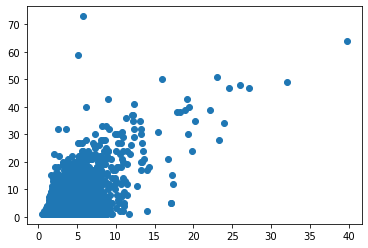

In [13]:
print("Test data")
predict_test=xgb.predict(X_test)
print('Mean Squared Error')
print(mean_squared_error(y_test,predict_test))
print('R2 score')
print(r2_score(y_test,predict_test))
plt.scatter(predict_test,y_test)
plt.show()

In [15]:
predict_test

array([2.5284214, 1.957314 , 1.795925 , ..., 1.8507375, 2.2311072,
       2.372784 ], dtype=float32)

In [12]:
# model save
xgb.load_model('./model2_1.model')

In [25]:
# model load
xgb.save_model('model2_1.model')

## 단속건수를 월, Grid에 대해서 Heat map 그리기

In [45]:
P=processed_data.loc[processed_data['단속건수']!=0,['단속건수','month','grid_num']]

In [50]:
df=P.pivot_table('단속건수',index='month',columns='grid_num',aggfunc='sum')
df

grid_num,0,1,3,4,5,6,7,8,9,10,...,14,15,16,17,19,20,21,22,23,24
month,,,,,,,,,,,,,,,,,,,,,
1,1724.0,950.0,3610.0,3778.0,NaN,2614.0,3925.0,NaN,7661.0,1905.0,...,NaN,2484.0,1176.0,NaN,3293.0,NaN,11.0,2682.0,845.0,8999.0
2,1593.0,1142.0,3107.0,3421.0,NaN,2152.0,3718.0,3.0,6883.0,1755.0,...,NaN,2077.0,985.0,NaN,2504.0,NaN,8.0,2360.0,742.0,8014.0
3,2282.0,1544.0,4801.0,4748.0,NaN,2983.0,5088.0,1.0,9263.0,2463.0,...,3.0,2633.0,1858.0,NaN,4072.0,1.0,19.0,3051.0,1149.0,10847.0
4,2349.0,1173.0,4542.0,5223.0,1.0,3365.0,5552.0,3.0,9554.0,2117.0,...,NaN,2756.0,1867.0,1.0,4413.0,NaN,11.0,3069.0,1111.0,10563.0
5,2390.0,1190.0,4138.0,4833.0,NaN,3032.0,5261.0,4.0,8073.0,1777.0,...,NaN,2915.0,1655.0,15.0,3639.0,NaN,8.0,3123.0,887.0,9161.0
6,2323.0,1140.0,4482.0,4673.0,5.0,2974.0,5051.0,1.0,8380.0,1905.0,...,NaN,3162.0,1512.0,NaN,3934.0,NaN,8.0,3130.0,964.0,9230.0
7,2184.0,1302.0,4313.0,4351.0,NaN,2863.0,4704.0,2.0,8129.0,1963.0,...,NaN,2625.0,1397.0,NaN,3432.0,NaN,5.0,2880.0,1081.0,9084.0
8,1877.0,1117.0,4107.0,4079.0,NaN,2479.0,4906.0,1.0,8060.0,1859.0,...,NaN,2679.0,1728.0,NaN,4038.0,NaN,10.0,3619.0,944.0,9463.0
9,1789.0,1000.0,3881.0,3753.0,NaN,2503.0,4182.0,4.0,6778.0,1564.0,...,NaN,2076.0,1291.0,4.0,3497.0,NaN,6.0,2468.0,798.0,7292.0


In [53]:
P2=processed_data.loc[processed_data['단속건수']!=0,['단속건수','month','grid_num']]
P2['단속건수']=xgb.predict(X_one)
df2=P2.pivot_table('단속건수',index='month',columns='grid_num',aggfunc='sum')
df2

grid_num,0,1,3,4,5,6,7,8,9,10,...,14,15,16,17,19,20,21,22,23,24
month,,,,,,,,,,,,,,,,,,,,,
1,1757.563599,1027.434570,3681.387207,3764.951416,NaN,2588.256592,4132.350586,NaN,7643.502930,1912.179321,...,NaN,2453.731445,1269.155518,NaN,3363.559082,NaN,17.230801,2790.717529,878.512146,8845.663086
2,1591.274658,1140.751709,3229.217285,3228.001221,NaN,2210.559570,3822.020020,6.787795,6815.116699,1779.881470,...,NaN,2285.631104,980.709778,NaN,2615.495361,NaN,13.743114,2402.576660,812.978943,7837.692383
3,2239.520264,1570.123291,4664.660156,4657.168457,NaN,2937.167480,5156.023926,2.214810,9106.923828,2332.950195,...,1.853461,2698.829102,1775.656860,NaN,4088.682129,2.497264,23.021128,3269.183838,1188.633301,10484.108398
4,2453.025146,1326.335449,4513.473145,4883.811035,2.004615,3186.172852,5263.192871,6.483716,9394.526367,2292.872070,...,NaN,2865.252441,1874.413940,2.162188,4396.058105,NaN,18.037388,3224.741699,1114.920044,10238.010742
5,2339.612793,1278.213867,4182.916016,4637.421875,NaN,2971.100830,5044.118652,8.056282,8264.184570,1839.258667,...,NaN,2868.165771,1651.976318,7.964620,3783.912109,NaN,12.671798,3087.977051,907.759705,9501.789062
6,2333.450439,1158.792358,4438.545898,4591.860840,3.293231,2992.486328,5063.327637,2.291489,8569.487305,2003.091431,...,NaN,3004.395996,1684.505127,NaN,3884.790039,NaN,12.438204,3240.243164,954.840515,9586.070312
7,2225.121582,1274.076050,4267.152832,4356.651367,NaN,2926.215332,4872.100586,4.103335,8242.841797,1934.700928,...,NaN,2665.790771,1504.138428,NaN,3608.774170,NaN,9.045501,2987.875488,1017.812988,8951.613281
8,2103.807861,1242.572144,4139.144531,4068.842041,NaN,2629.301025,4706.510742,2.052848,7810.688965,1987.406372,...,NaN,2656.928955,1725.779053,NaN,3894.299805,NaN,13.900341,3331.838867,1041.258545,9226.886719
9,1786.293823,1000.347717,3714.859863,3727.541016,NaN,2440.071533,3999.913574,3.452412,6803.545898,1556.009888,...,NaN,2112.655518,1238.223022,2.570640,3271.069092,NaN,6.912595,2486.086182,900.429321,7487.308105


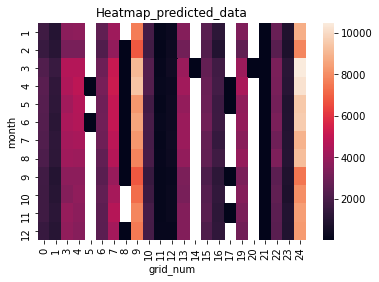

In [54]:
ax=sns.heatmap(df2)
plt.title('Heatmap_predicted_data')
plt.show()

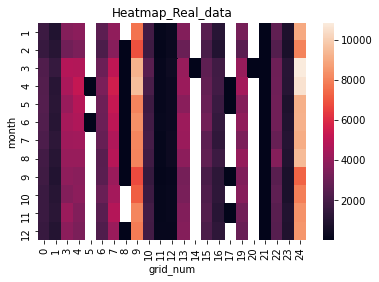

In [51]:
ax=sns.heatmap(df)
plt.title('Heatmap_Real_data')
plt.show()

# 관측개수 확률로 변환

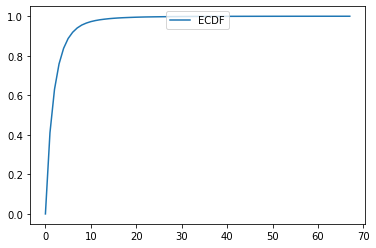

In [31]:
from statsmodels.distributions.empirical_distribution import ECDF
ecdf=ECDF(y)
np.save('./empirical_num_1',y_train,allow_pickle=True)
slope_changes = sorted(set(processed_data.단속건수.tolist()))
sample_edf_values_at_slope_changes = [ ecdf(item) for item in slope_changes]
plt.plot(sample_edf_values_at_slope_changes,label='ECDF')
plt.legend(loc=9)

In [32]:
predict_test

array([2.2181497, 1.8648423, 4.990609 , ..., 2.19416  , 5.704258 ,
       2.150274 ], dtype=float32)